<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_EGLMS_Project/blob/main/%5BExp_7%5D_Camera_stickers(CV).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Exp_7] Camera_stickers(CV)

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

print(cv2.__version__)
print(dlib.__version__)

4.6.0
19.24.0


## 1.이미지 가져오기

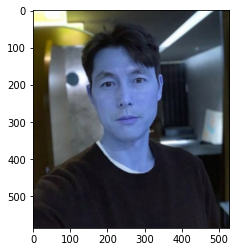

In [2]:
my_image_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/camera_stickers/camera_image/정우성_1.png"
img_bgr = cv2.imread(my_image_path)    
img_show = img_bgr.copy()      
plt.imshow(img_bgr)
plt.show()

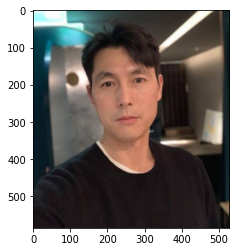

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2. 얼굴 검출 및 랜드마크 검출
- 오늘 배운 dlib을 이용해서 얼굴의 bounding box 위치와 landmark의 위치를 찾아주세요.

In [4]:
detector_hog = dlib.get_frontal_face_detector()

In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

rectangles[[(159, 139) (345, 325)]]


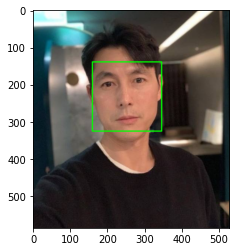

In [6]:
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb_1 =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_1)
plt.show()

In [7]:
! wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

--2022-08-14 12:50:38--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  87.4MB/s    in 0.7s    

2022-08-14 12:50:39 (87.4 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [8]:
! mv shape_predictor_68_face_landmarks.dat.bz2 /content/drive/MyDrive/인공지능/아이펠/ES/data/camera_stickers/camera_models

In [9]:
!cd /content/drive/MyDrive/인공지능/아이펠/ES/data/camera_stickers && bzip2 -d ./camera_models/shape_predictor_68_face_landmarks.dat.bz2

bzip2: Output file ./camera_models/shape_predictor_68_face_landmarks.dat already exists.


In [10]:
model_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/camera_stickers/camera_models/shape_predictor_68_face_landmarks.dat"
landmark_predictor = dlib.shape_predictor(model_path)

In [11]:
list_landmarks = []

# 얼굴 영역 박스마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
  points = landmark_predictor(img_rgb, dlib_rect)
  # face landmark 좌표를 저장해 둡니다.
  list_points = list(map(lambda p : (p.x,p.y), points.parts()))
  list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


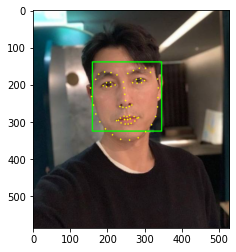

In [12]:
for landmark in list_landmarks:

  for point in landmark:

    cv2.circle(img_show, point, 2,(0,255,255),-1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3. 스티커 적용 위치 확인
- 고양이 수염이 적용 될 위치를 landmark를 사용해서 계산

In [13]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(248, 243)
(x,y) : (248,150)
(w,h) : (187,187)


In [14]:
sticker_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/camera_stickers/sticker_image/cat-whiskers.png"
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))

print (img_sticker.shape)

(187, 187, 3)


In [15]:
refined_x = x - w // 2
refined_y = y 
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (155,150)


In [16]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (155,150)


## 4. 스티커 적용하기
- 오늘 배운 np.where를 사용해서 스티커를 적용
- 스티커를 조금 더 자연스럽게 보이게 하려면 어떻게 해야 할까요? 스티커 뒤로 원본 이미지가 같이 보이도록 만들어 봅시다. opencv 의 cv2.addWeighted() 를 참고하세요.

In [17]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker>=255,sticker_area,img_sticker).astype(np.uint8)

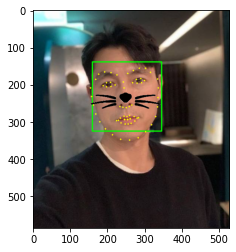

In [18]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))

plt.show()

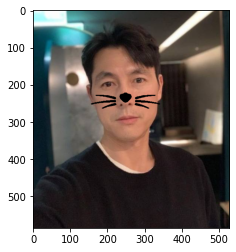

In [19]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker>0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))

plt.show()

## 5. 문제점 찾아보기
- 셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보세요.

- 문제점이 무엇인지 최대한 자세하게 기록해 보세요. 여러분이 생각한 문제점을 해결하기 위한 방법은 분명 존재합니다!

  - 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
  - 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
  - 실행 속도가 중요할까요?
  - 스티커앱을 만들 때 정확도가 얼마나 중요할까요?

## 1. 이미지 가져오기

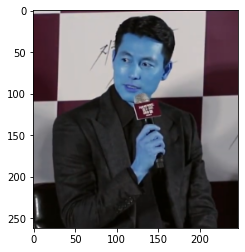

In [20]:
my_image_path_2 = "/content/drive/MyDrive/인공지능/아이펠/ES/data/camera_stickers/camera_image/정우성_2.png"
img_bgr_2 = cv2.imread(my_image_path_2)    
img_show_2 = img_bgr_2.copy()      
plt.imshow(img_bgr_2)
plt.show()

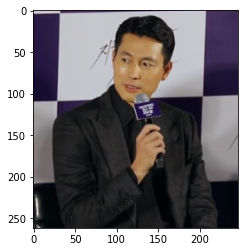

In [21]:
img_rgb_2 = cv2.cvtColor(img_bgr_2, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_2)
plt.show()

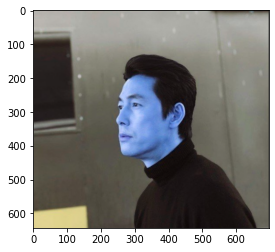

In [22]:
my_image_path_3 = "/content/drive/MyDrive/인공지능/아이펠/ES/data/camera_stickers/camera_image/정우성_3.png"
img_bgr_3 = cv2.imread(my_image_path_3)    
img_show_3 = img_bgr_3.copy()      
plt.imshow(img_bgr_3)
plt.show()

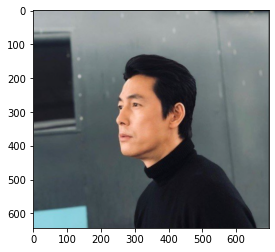

In [23]:
img_rgb_3 = cv2.cvtColor(img_bgr_3, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_3)
plt.show()

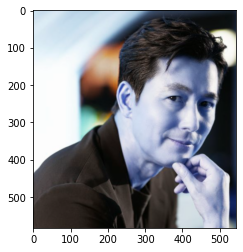

In [24]:
my_image_path_4 = "/content/drive/MyDrive/인공지능/아이펠/ES/data/camera_stickers/camera_image/정우성_4.png"
img_bgr_4 = cv2.imread(my_image_path_4)    
img_show_4 = img_bgr_4.copy()      
plt.imshow(img_bgr_4)
plt.show()

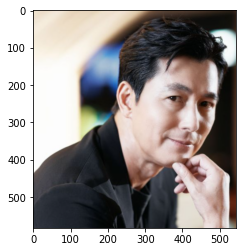

In [25]:
img_rgb_4 = cv2.cvtColor(img_bgr_4, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_4)
plt.show()

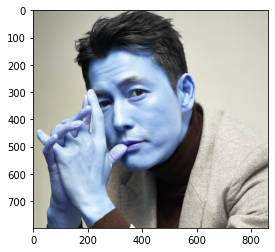

In [26]:
my_image_path_5 = "/content/drive/MyDrive/인공지능/아이펠/ES/data/camera_stickers/camera_image/정우성_5.png"
img_bgr_5 = cv2.imread(my_image_path_5)    
img_show_5 = img_bgr_5.copy()      
plt.imshow(img_bgr_5)
plt.show()

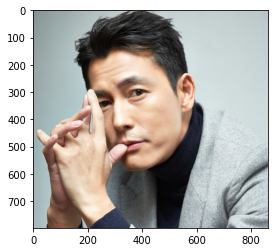

In [27]:
img_rgb_5 = cv2.cvtColor(img_bgr_5, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_5)
plt.show()

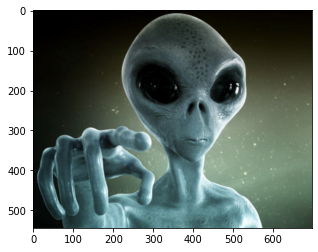

In [28]:
my_image_path_6 = "/content/drive/MyDrive/인공지능/아이펠/ES/data/camera_stickers/camera_image/정우성_6.png"
img_bgr_6 = cv2.imread(my_image_path_6)    
img_show_6 = img_bgr_6.copy()      
plt.imshow(img_bgr_6)
plt.show()

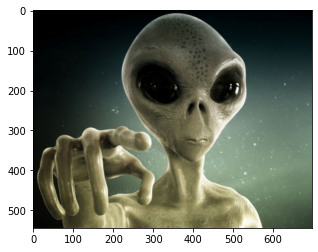

In [29]:
img_rgb_6 = cv2.cvtColor(img_bgr_6, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_6)
plt.show()

## 2. 얼굴 검출 및 랜드마크 검출

In [30]:
detector_hog = dlib.get_frontal_face_detector()

In [31]:
img_rgb_2 = cv2.cvtColor(img_bgr_2, cv2.COLOR_BGR2RGB)
dlib_rects_2 = detector_hog(img_rgb_2, 1)

rectangles[[(93, 46) (156, 108)]]


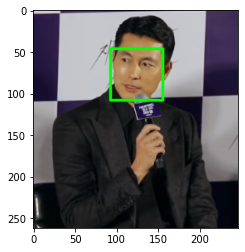

In [32]:
print(dlib_rects_2)   

for dlib_rect in dlib_rects_2:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show_2, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb_2 =  cv2.cvtColor(img_show_2, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_2)
plt.show()

In [33]:
img_rgb_3 = cv2.cvtColor(img_bgr_3, cv2.COLOR_BGR2RGB)
dlib_rects_3 = detector_hog(img_rgb_3, 1)

rectangles[[(201, 222) (386, 407)]]


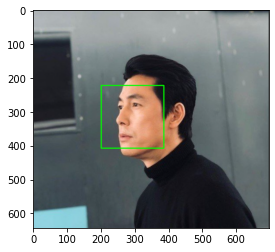

In [34]:
print(dlib_rects_3)   

for dlib_rect in dlib_rects_3:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
  
    cv2.rectangle(img_show_3, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb_3 =  cv2.cvtColor(img_show_3, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_3)
plt.show()

In [35]:
img_rgb_4 = cv2.cvtColor(img_bgr_4, cv2.COLOR_BGR2RGB)
dlib_rects_4 = detector_hog(img_rgb_4, 1)

rectangles[[(291, 167) (513, 390)]]


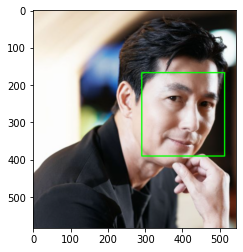

In [36]:
print(dlib_rects_4)   

for dlib_rect in dlib_rects_4:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
   
    cv2.rectangle(img_show_4, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb_4 =  cv2.cvtColor(img_show_4, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_4)
plt.show()

In [37]:
img_rgb_5 = cv2.cvtColor(img_bgr_5, cv2.COLOR_BGR2RGB)
dlib_rects_5 = detector_hog(img_rgb_5, 1)

rectangles[[(170, 206) (491, 527)]]


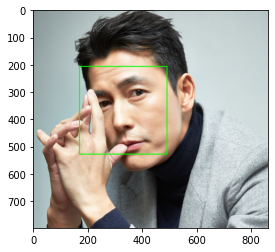

In [38]:
print(dlib_rects_5)   

for dlib_rect in dlib_rects_5:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show_5, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb_5 =  cv2.cvtColor(img_show_5, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_5)
plt.show()

In [39]:
img_rgb_6 = cv2.cvtColor(img_bgr_6, cv2.COLOR_BGR2RGB)
dlib_rects_6 = detector_hog(img_rgb_6, 1)

rectangles[]


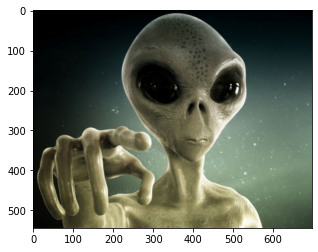

In [40]:
print(dlib_rects_6)   

for dlib_rect in dlib_rects_6:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show_6, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb_6 =  cv2.cvtColor(img_show_6, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_6)
plt.show()

In [41]:
list_landmarks_2 = []

# 얼굴 영역 박스마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects_2:
  points = landmark_predictor(img_rgb_2, dlib_rect)
  # face landmark 좌표를 저장해 둡니다.
  list_points = list(map(lambda p : (p.x,p.y), points.parts()))
  list_landmarks_2.append(list_points)

print(len(list_landmarks_2[0]))

68


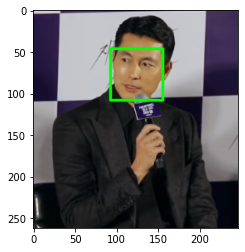

In [42]:
for landmark in list_landmarks_2:

  for point in landmark:

    cv2.circle(img_show_rgb_2, point, 2,(0,255,255),-1)

img_show_rgb_2 = cv2.cvtColor(img_show_2, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_2)
plt.show()

In [43]:
list_landmarks_3 = []

# 얼굴 영역 박스마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects_3:
  points = landmark_predictor(img_rgb_3, dlib_rect)
  # face landmark 좌표를 저장해 둡니다.
  list_points = list(map(lambda p : (p.x,p.y), points.parts()))
  list_landmarks_3.append(list_points)

print(len(list_landmarks_3[0]))

68


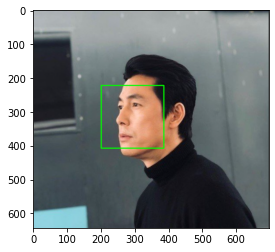

In [44]:
for landmark in list_landmarks_3:

  for point in landmark:

    cv2.circle(img_show_rgb_3, point, 2,(0,255,255),-1)

img_show_rgb_3 = cv2.cvtColor(img_show_3, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_3)
plt.show()

In [45]:
list_landmarks_4 = []

# 얼굴 영역 박스마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects_4:
  points = landmark_predictor(img_rgb_4, dlib_rect)
  # face landmark 좌표를 저장해 둡니다.
  list_points = list(map(lambda p : (p.x,p.y), points.parts()))
  list_landmarks_4.append(list_points)

print(len(list_landmarks_4[0]))

68


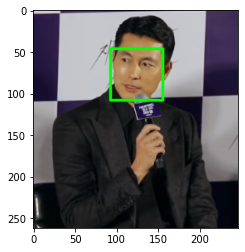

In [46]:
for landmark in list_landmarks_4:

  for point in landmark:

    cv2.circle(img_show_rgb_4, point, 2,(0,255,255),-1)

img_show_rgb_4 = cv2.cvtColor(img_show_4, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_2)
plt.show()

In [47]:
list_landmarks_5 = []

# 얼굴 영역 박스마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects_5:
  points = landmark_predictor(img_rgb_5, dlib_rect)
  # face landmark 좌표를 저장해 둡니다.
  list_points = list(map(lambda p : (p.x,p.y), points.parts()))
  list_landmarks_5.append(list_points)

print(len(list_landmarks_5[0]))

68


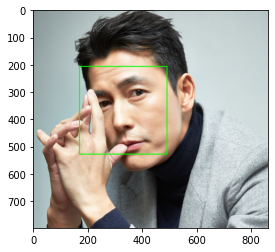

In [48]:
for landmark in list_landmarks_5:

  for point in landmark:

    cv2.circle(img_show_rgb_5, point, 2,(0,255,255),-1)

img_show_rgb_5 = cv2.cvtColor(img_show_5, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_5)
plt.show()

In [49]:
# list_landmarks_6 = []

# # 얼굴 영역 박스마다 face landmark를 찾아냅니다
# for dlib_rect in dlib_rects_6:
#   points = landmark_predictor(img_rgb_6, dlib_rect)
#   # face landmark 좌표를 저장해 둡니다.
#   list_points = list(map(lambda p : (p.x,p.y), points.parts()))
#   list_landmarks_6.append(list_points)

# print(len(list_landmarks_6[0]))

In [50]:
# for landmark in list_landmarks_6:

#   for point in landmark:

#     cv2.circle(img_show_rgb_6, point, 2,(0,255,255),-1)

# img_show_rgb_6 = cv2.cvtColor(img_show_6, cv2.COLOR_BGR2RGB)
# plt.imshow(img_show_rgb_6)
# plt.show()

## 3. 스티커 적용 위치 확인

In [72]:
sticker_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/camera_stickers/sticker_image/cat-whiskers.png"
img_sticker_2 = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker_2 = cv2.resize(img_sticker_2, (w,h))

print (img_sticker_2.shape)

(322, 322, 3)


In [73]:
sticker_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/camera_stickers/sticker_image/cat-whiskers.png"
img_sticker_3 = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker_3 = cv2.resize(img_sticker_3, (w,h))

print (img_sticker_3.shape)

(322, 322, 3)


In [74]:
sticker_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/camera_stickers/sticker_image/cat-whiskers.png"
img_sticker_4 = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker_4 = cv2.resize(img_sticker_4, (w,h))

print (img_sticker_4.shape)

(322, 322, 3)


In [75]:
sticker_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/camera_stickers/sticker_image/cat-whiskers.png"
img_sticker_5 = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker_5 = cv2.resize(img_sticker_5, (w,h))

print (img_sticker_5.shape)

(322, 322, 3)


In [76]:
for dlib_rect, landmark in zip(dlib_rects_2, list_landmarks_2):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(121, 79)
(x,y) : (121,48)
(w,h) : (64,64)


In [77]:
refined_x_2 = x - w // 2
refined_y_2 = y 
print ('(x,y) : (%d,%d)'%(refined_x_2, refined_y_2))

(x,y) : (89,48)


In [78]:
if refined_x_2 < 0: 
    img_sticker = img_sticker[:, -refined_x_2:]
    refined_x_2 = 0
if refined_y_2 < 0:
    img_sticker = img_sticker[-refined_y_2:, :]
    refined_y_2 = 0

print ('(x,y) : (%d,%d)'%(refined_x_2, refined_y_2))

(x,y) : (89,48)


In [79]:
for dlib_rect, landmark in zip(dlib_rects_3, list_landmarks_3):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(249, 324)
(x,y) : (249,231)
(w,h) : (186,186)


In [80]:
refined_x_3 = x - w // 2
refined_y_3 = y 
print ('(x,y) : (%d,%d)'%(refined_x_3, refined_y_3))

(x,y) : (156,231)


In [81]:
if refined_x_3 < 0: 
    img_sticker = img_sticker[:, -refined_x_3:]
    refined_x_3 = 0
if refined_y_3 < 0:
    img_sticker = img_sticker[-refined_y_3:, :]
    refined_y_3 = 0

print ('(x,y) : (%d,%d)'%(refined_x_3, refined_y_3))

(x,y) : (156,231)


In [82]:
for dlib_rect, landmark in zip(dlib_rects_4, list_landmarks_4):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(443, 307)
(x,y) : (443,195)
(w,h) : (223,223)


In [83]:
refined_x_4 = x - w // 2
refined_y_4 = y 
print ('(x,y) : (%d,%d)'%(refined_x_4, refined_y_4))

(x,y) : (332,195)


In [84]:
if refined_x_4 < 0: 
    img_sticker = img_sticker[:, -refined_x_4:]
    refined_x_4 = 0
if refined_y_4 < 0:
    img_sticker = img_sticker[-refined_y_4:, :]
    refined_y_4 = 0

print ('(x,y) : (%d,%d)'%(refined_x_4, refined_y_4))

(x,y) : (332,195)


In [85]:
for dlib_rect, landmark in zip(dlib_rects_5, list_landmarks_5):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(308, 414)
(x,y) : (308,253)
(w,h) : (322,322)


In [86]:
refined_x_5 = x - w // 2
refined_y_5 = y 
print ('(x,y) : (%d,%d)'%(refined_x_5, refined_y_5))

(x,y) : (147,253)


In [87]:
if refined_x_5 < 0: 
    img_sticker = img_sticker[:, -refined_x_5:]
    refined_x_5 = 0
if refined_y_5 < 0:
    img_sticker = img_sticker[-refined_y_5:, :]
    refined_y_5 = 0

print ('(x,y) : (%d,%d)'%(refined_x_5, refined_y_5))

(x,y) : (147,253)


In [88]:
# for dlib_rect, landmark in zip(dlib_rects_6, list_landmarks_6):
#     print (landmark[30]) # 코의 index는 30 입니다
#     x = landmark[30][0]
#     y = landmark[30][1] - dlib_rect.height()//2
#     w = h = dlib_rect.width()
#     print ('(x,y) : (%d,%d)'%(x,y))
#     print ('(w,h) : (%d,%d)'%(w,h))

In [89]:
# refined_x_6 = x - w // 2
# refined_y_6 = y 
# print ('(x,y) : (%d,%d)'%(refined_x_6, refined_y_6))

In [90]:
# if refined_x_6 < 0: 
#     img_sticker = img_sticker[:, -refined_x_6:]
#     refined_x_6 = 0
# if refined_y_6 < 0:
#     img_sticker = img_sticker[-refined_y_6:, :]
#     refined_y_6 = 0

# print ('(x,y) : (%d,%d)'%(refined_x_6, refined_y_6))

## 4. 스티커 적용하기

In [66]:
sticker_area_2 = img_show_2[refined_y_2:refined_y_2+img_sticker_2.shape[0], refined_x_2:refined_x_2+img_sticker_2.shape[1]]
img_show_2[refined_y_2:refined_y_2+img_sticker.shape[0], refined_x_2:refined_x_2+img_sticker.shape[1]] = \
    np.where(img_sticker>=255,sticker_area_2,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show_2, cv2.COLOR_BGR2RGB))

plt.show()

ValueError: ignored

In [67]:
sticker_area_2 = img_bgr_2[refined_y_2:refined_y_2 +img_sticker.shape[0], refined_x_2:refined_x_2+img_sticker.shape[1]]
img_bgr_2[refined_y_2:refined_y_2 +img_sticker.shape[0], refined_x_2:refined_x_2+img_sticker.shape[1]] = \
    np.where(img_sticker>0,sticker_area_2,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr_2, cv2.COLOR_BGR2RGB))

plt.show()

ValueError: ignored

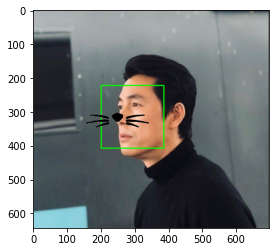

In [68]:
sticker_area_3 = img_show_3[refined_y_3:refined_y_3+img_sticker.shape[0], refined_x_3:refined_x_3+img_sticker.shape[1]]
img_show_3[refined_y_3:refined_y_3+img_sticker.shape[0], refined_x_3:refined_x_3+img_sticker.shape[1]] = \
    np.where(img_sticker>=255,sticker_area_3,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show_3, cv2.COLOR_BGR2RGB))

plt.show()

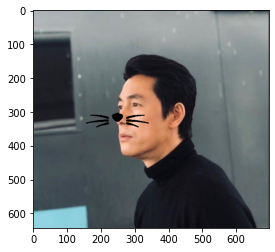

In [69]:
sticker_area_3 = img_bgr_3[refined_y_3:refined_y_3 +img_sticker.shape[0], refined_x_3:refined_x_3+img_sticker.shape[1]]
img_bgr_3[refined_y_3:refined_y_3 +img_sticker.shape[0], refined_x_3:refined_x_3+img_sticker.shape[1]] = \
    np.where(img_sticker>0,sticker_area_3,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr_3, cv2.COLOR_BGR2RGB))

plt.show()

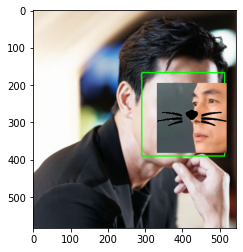

In [70]:
sticker_area_4 = img_show_4[refined_y_4:refined_y_4+img_sticker.shape[0], refined_x_4:refined_x_4+img_sticker.shape[1]]
img_show_4[refined_y_4:refined_y_4+img_sticker.shape[0], refined_x_4:refined_x_4+img_sticker.shape[1]] = \
    np.where(img_sticker>=255,sticker_area_3,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show_4, cv2.COLOR_BGR2RGB))

plt.show()

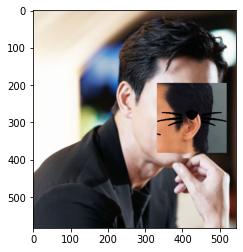

In [71]:
sticker_area_4 = img_bgr_3[refined_y_4:refined_y_4 +img_sticker.shape[0], refined_x_4:refined_x_4+img_sticker.shape[1]]
img_bgr_4[refined_y_4:refined_y_4 +img_sticker.shape[0], refined_x_4:refined_x_4+img_sticker.shape[1]] = \
    np.where(img_sticker>0,sticker_area_4,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr_4, cv2.COLOR_BGR2RGB))

plt.show()